# Normalizing structure factor amplitudes for anomalous data

In subsequent notebooks, we'd like to compare pairs of datasets. This notebook follows the approach in _Notebook 1_, except that the paired datasets are the two halves of reciprocal space. 

To compare structure factor amplitudes, $|F_{hkl}|$, we first normalize them such that the normalized structure factor amplitudes, $|E_{hkl}|$, on average obey $\left<|E|^2\right>=1$.  For various reasons, measured amplitudes do depend on resolution and their average may vary across reciprocal space. Some of these effects are intrinsic to the crystals: molecular disorder and the finite size of atoms lead to a decrease in measured amplitudes with resolution; primary and secondary structure leads to deviations from random atom models. However, to facilitate comparison, we preprocess the data to remove systematic variations in the magnitude of amplitudes across reciprocal space--to the extent that such variation is supported by cross-validation. 

Preprocessing proceeds in four steps:

1. **Basic scaling**. First the $|F|$ and $\sigma_F$ are divided by the average $|F|$.
2. **Simple anisotropic normalization**. An overall scale factor and anisotropic B matrix are fit to maximize the fit to the Wilson distribution (centric and acentric) for normalized amplitudes.
3. **Anisotropic normalization with Fourier corrections.** Any systematic variation across reciprocal space that can be removed using a third- or fourth order Fourier series is removed. 15\% of the data are kept out to determine the optimal order by cross-validation.
4. **Normalization by regression estimates of the scale factor $\Sigma$**. By similar logic, a _k_-nearest neighbor estimator is used to predict the $F^2$ at each location in reciprocal space. The optimal _k_ and weight function are inferred again by cross-validation. We then normalize each structure factor amplitude by its kNN-predicted value.

After this preprocessing, we see that plots of $\left<|E|^2\right>$ versus resolution become flatter and get closer to $1$. 

# Preprocessing of individual datasets
- The entire process for a single dataset takes 2-5 minutes total (up to n=4) or 10-15 min (with n=5).
- We've observed that the preprocessing is, ironically, most complicated for datasets which have been French-Wilson (FW) scaled: in such datasets, noisy reflections are overrepresented near the mean of the Wilson distributions, and this skews normalization. In the second step of anisotropic scaling, I added weights to diminish the effects of the noisy reflections.

In [50]:
# General tools
%matplotlib inline
import matplotlib.pyplot as plt
import numpy   as np
import warnings
from mpl_toolkits    import mplot3d
from scipy.stats     import rice, foldnorm, nakagami, gamma 
from scipy.optimize  import least_squares, minimize
from time            import perf_counter

t_overall_start = perf_counter()

In [51]:
import reciprocalspaceship as rs
import gemmi
from dw_tools import modify_ds, wilson, plots
from dw_tools import aniso_scaling_step_1 as aniso1
from dw_tools import aniso_scaling_step_2 as aniso2
from dw_tools import knn_tools as knn
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors       import KNeighborsRegressor
rs.__version__

'1.0.1'

In [52]:
%autosave 300
%load_ext autoreload
%autoreload 2

Autosaving every 300 seconds
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [53]:
path="double_wilson_data/NECAT_HEWL_RT_NaI/"    # Unix
mtz1 = "NECAT_HEWL_RT_NaI_82_XDS_scaled1"
ds1=rs.read_mtz(path + mtz1 + ".mtz")

ds1["I(-)"]=np.maximum(0.01,ds1["I(-)"].to_numpy())
ds1["I(+)"]=np.maximum(0.01,ds1["I(+)"].to_numpy())
ds1 = ds1[(ds1["I(+)"]>=0) & (ds1["I(-)"]>=0)]
ds1["FP+"]=np.sqrt( ds1["I(-)"])
ds1["FP-"]=np.sqrt( ds1["I(+)"])
ds1["SIGFP+"] = 0.5*(ds1["SIGI(-)"])/ds1["FP+"]
ds1["SIGFP-"] = 0.5*(ds1["SIGI(+)"])/ds1["FP-"]
# ds1=ds1.dropna()  
ds1.info()

# cleanup:
unpurged_count = ds1.shape[0];   ds1.dropna(inplace=True)
purged_count   = ds1.shape[0]
print(f"Discarded {unpurged_count-purged_count} out of {unpurged_count} records")

<class 'reciprocalspaceship.dataset.DataSet'>
MultiIndex: 33281 entries, (0, 0, 4) to (63, 2, 1)
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   FreeR_flag  33281 non-null  MTZInt        
 1   IMEAN       33281 non-null  Intensity     
 2   SIGIMEAN    33281 non-null  Stddev        
 3   I(+)        33281 non-null  float32       
 4   SIGI(+)     33281 non-null  StddevFriedelI
 5   I(-)        33281 non-null  float32       
 6   SIGI(-)     33281 non-null  StddevFriedelI
 7   N(+)        33281 non-null  MTZInt        
 8   N(-)        33281 non-null  MTZInt        
 9   FP+         33281 non-null  float32       
 10  FP-         33281 non-null  float32       
 11  SIGFP+      33281 non-null  StddevFriedelI
 12  SIGFP-      33281 non-null  StddevFriedelI
dtypes: Intensity(1), MTZInt(3), Stddev(1), StddevFriedelI(4), float32(4)
memory usage: 2.0 MB
Discarded 0 out of 33281 records


## 1. Basic scaling

Let's inspect $\left< F \right>$ by resolution bin.

Average observations per bin: 1664.05
Average observations per bin: 1664.05


(0.0, 29.469066506624223)

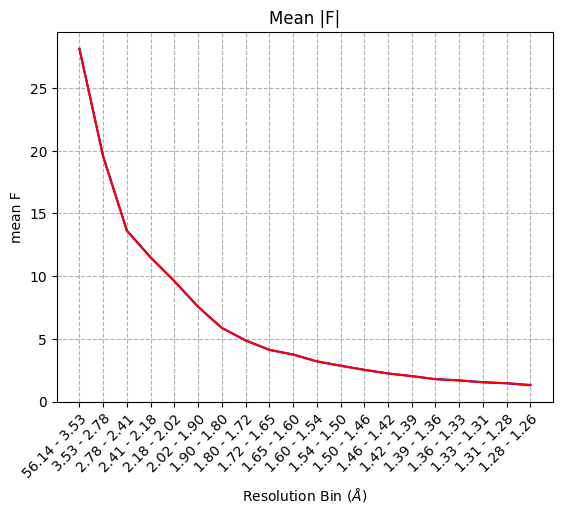

In [54]:
result, bin_labels = plots.compute_meanF_byres(ds1, label="FP+", nbins=20,sigma_cut=0)
plots.plot_by_res_bin(result, bin_labels, ylabel="mean F",color='b')
result, bin_labels = plots.compute_meanF_byres(ds1, label="FP-", nbins=20,sigma_cut=0)
plots.plot_by_res_bin(result, bin_labels, ylabel="mean F",color='r')
plt.title("Mean |F|")
plt.ylim(0,)

Some very basic scaling:

In [55]:
avg = ds1["FP+"].mean()
ds1["FP+"] = ds1["FP+"]/avg
ds1["SIGFP+"] = ds1["SIGFP+"]/avg
ds1["FP-"] = ds1["FP-"]/avg
ds1["SIGFP-"] = ds1["SIGFP-"]/avg

Additionally, let's add reciprocal lattice point coordinates, ```dHKL```, (a)centric labels, and multiplicities!

In [56]:
modify_ds.ds_add_rs(ds1)
ds1.compute_dHKL(        inplace=True)
ds1.label_centrics(      inplace=True)
ds1.compute_multiplicity(inplace=True)

FreeR_flag        IMEAN   SIGIMEAN         I(+)    SIGI(+)  \
H  K L                                                                
0  0 4           11   223.427567   2.413615   223.427567   2.413615   
     8           13  2715.550293  21.721418  2715.550293  21.721418   
     12           1  1283.327515  10.446491  1283.327515  10.446491   
     16           4  2649.441895  20.488834  2649.441895  20.488834   
     20          10    -0.014324   0.339255     0.010000   0.339255   
...             ...          ...        ...          ...        ...   
63 0 1           12     0.592224   1.142937     0.592224   1.142937   
   1 0           10    -0.171097   0.517193     0.010000   0.517193   
     1           16     1.309491   0.990904     1.942743   1.207675   
   2 0           15    -1.459511   0.753383     0.010000   0.753383   
     1           17    -0.416487   1.253705     0.010000   0.000000   

                I(-)    SIGI(-)  N(+)  N(-)       FP+       FP-    SIGFP+  \
H  K L                                                                      
0  0 4    223.427567   2.413615    24    24  2.314881  2.314881  0.012503   
     8   2715.550293  21.721418    22    22  8.070293  8.070293  0.032277   
     12  1283.327515  10.446491    24    24  5.547907  5.547907  0.022580   
     16  2649.441895  20.488834    24    24  7.971455  7.971455  0.030823   
     20     0.010000   0.339255    24    24  0.015487  0.015487  0.262698   
...              ...        ...   ...   ...       ...       ...       ...   
63 0 1      0.592224   1.142937     4     4  0.119180  0.119180  0.115003   
   1 0      0.010000   0.517193    12    12  0.015487  0.015487  0.400482   
     1      0.010000   1.733444     3     2  0.015487  0.215858  1.342271   
   2 0      0.010000   0.753383     6     6  0.015487  0.015487  0.583373   
     1      0.010000   1.253705     0     2  0.015487  0.015487  0.970791   

           SIGFP-      rs_a      rs_b      rs_c      dHKL  CENTRIC  EPSILON  
H  K L                                                                       
0  0 4   0.012503  0.000000  0.000000  0.105743  9.456925     True        4  
     8   0.032277  0.000000  0.000000  0.211485  4.728463     True        4  
     12  0.022580  0.000000  0.000000  0.317228  3.152308     True        4  
     16  0.030823  0.000000  0.000000  0.422970  2.364231     True        4  
     20  0.262698  0.000000  0.000000  0.528713  1.891385     True        4  
...           ...       ...       ...       ...       ...      ...      ...  
63 0 1   0.115003  0.793568  0.000000  0.026436  1.259433     True        1  
   1 0   0.400482  0.793568  0.012596  0.000000  1.259973     True        1  
     1   0.067092  0.793568  0.012596  0.026436  1.259275    False        1  
   2 0   0.583373  0.793568  0.025193  0.000000  1.259497     True        1  
     1   0.000000  0.793568  0.025193  0.026436  1.258800    False        1  

[33281 rows x 19 columns]

### Checking reciprocal space (ASU) coverage
Let's see what chunk of reciprocal space these reflections are located in. 

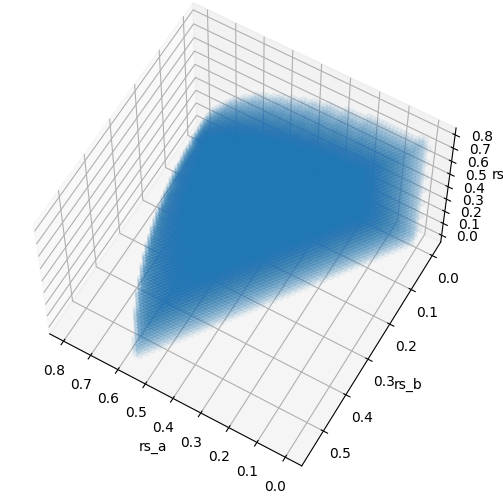

In [57]:
plt.ion
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection="3d")
ax.scatter3D(ds1["rs_a"], ds1["rs_b"], ds1["rs_c"],alpha=0.05)
ax.view_init(elev=60., azim=1200.)
ax.set_xlabel("rs_a")
ax.set_ylabel("rs_b")
ax.set_zlabel("rs_c")
plt.draw()

## 2. Simple anisotropic normalization.
First, we fit an anisotropic $B$ factor scaling model to the data using the Wilson distribution as the loss function. This provides our first version of normalized structure factors. Numerical warnings are typically inconsequential. We perform this normalization separately for the $F(+)$ and $F(-)$ Friedel mates.

In [58]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    res_p = minimize(              aniso1.anisotropic_scaling_to_1_wilson_loss, [0,0,0,0,0,0,1],\
                                                                    method='L-BFGS-B',jac=True,args=(ds1,"FP+"))
    res_test_p, ep1_p, sigep1_p = aniso1.anisotropic_scaling_to_1_wilson_loss(res_p.x, ds1, label="FP+", nargout=3)
    print(res_p.x)
    
    res_m = minimize(             aniso1.anisotropic_scaling_to_1_wilson_loss, [0,0,0,0,0,0,1],\
                                                                    method='L-BFGS-B',jac=True,args=(ds1,"FP-"))
    res_test_m, ep1_m, sigep1_m = aniso1.anisotropic_scaling_to_1_wilson_loss(res_m.x, ds1, label="FP-", nargout=3)
    print(res_m.x)

ds1["EP+"] = ep1_p
ds1["EP-"] = ep1_m
ds1["SIGEP+"] = sigep1_p
ds1["SIGEP-"] = sigep1_m

[-5.16343274 -0.0316708  -0.1049163  -4.96999467  0.14077499 -5.61870713
  0.1804048 ]
[-5.15853771 -0.01804997 -0.10090431 -4.98513453  0.14326899 -5.60191098
  0.18125365]


### Inspection of histograms. 


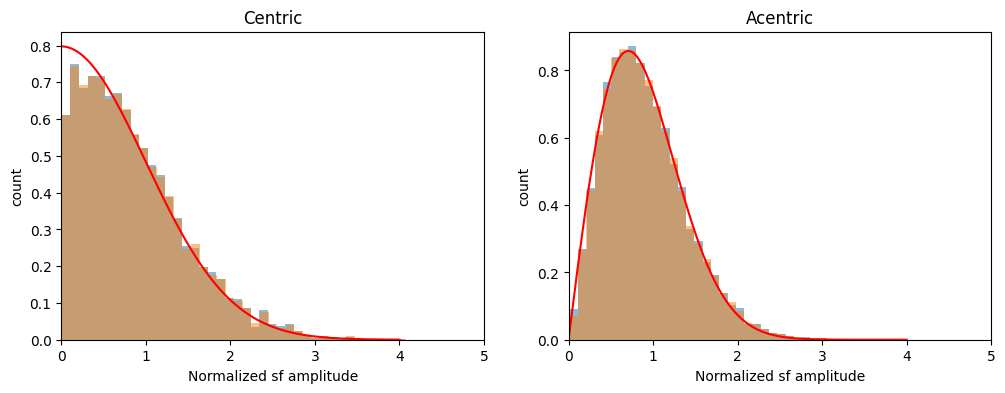

In [59]:
sig_cut = 0.1 

x=np.linspace(0,4,500)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(ep1_p[(ds1["CENTRIC"]==True) & (sigep1_p<sig_cut)],40,alpha=0.5,density=True)
plt.hist(ep1_m[(ds1["CENTRIC"]==True) & (sigep1_m<sig_cut)],40,alpha=0.5,density=True)
plt.plot(x,wilson.wilson_dist_normalized(x,centric=True),'r-') 
plt.ylabel("count"); plt.xlabel("Normalized sf amplitude")
plt.xlim([0,5])
plt.title("Centric")

plt.subplot(1,2,2)
plt.hist(ep1_p[(ds1["CENTRIC"]==False) & (sigep1_p<sig_cut)],40,alpha=0.5,density=True)
plt.hist(ep1_m[(ds1["CENTRIC"]==False) & (sigep1_m<sig_cut)],40,alpha=0.5,density=True)
plt.plot(x, wilson.wilson_dist_normalized(x,centric=False),'r-')
plt.ylabel("count"); plt.xlabel("Normalized sf amplitude")
plt.xlim([0,5])
plt.title("Acentric"); 

## 3. Anisotropic normalization with Fourier corrections

Since we're using quite a few parameters, we'll use a test set to choose the optimal order of the Fourier series.


In [60]:
rseed=1763
np.random.seed(rseed)
ds1["test_flag"] = (np.random.random((ds1.shape[0],1)) <0.85)

### Corrections for the $+$ Friedel mates.

Often, datasets at this point still show slowly varying average amplitudes across reciprocal space.
In this section, we calculate a pattern of correction coefficients in reciprocal space that improves upon the above anisotropic scaling corrections. We do so using a Fourier series. That is, 

$$
C_{hkl} = A_0 + \sum_{m,n,p} A_{mnp} \cos(2\pi h^T m/L) + B_{mnp} \sin(2\pi h^T m/L)
$$

with $h=(h,k,l)$ the Miller indices and $m=(m,n,p)$ the 3D Fourier component indices. We test the optimal order of the Fourier series by cross-validation (the upper limit for $m,n,p$).

The loss is determined by the fit of the data to Wilson distribution for normalized structure factor amplitudes.

In [61]:
# typically the minimum is for n=3 or 4...
# see right below for typical run times by n (n=4: 2-3 min total)
# note that at higher values of n sometimes NaNs pop up

res=[0] # start with a dummy so next entries match their n
n_best = 0
best_loss = 9e9
for n in [1,2,3,4]:
    t1_start = perf_counter()
    params = aniso2.prepare_for_FFT(ds1, n=n, label="EP+")
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        init_guess = np.zeros((1,2*(n**3)))
        if n>1:
            init_guess[0,:res[-1].x.shape[0]]=res[-1].x
        else:
            init_guess[0]=np.array([1, 0])
        res_tmp = minimize(aniso2.anisotropic_scaling_to_1_FFT_wilson_loss_fast, \
                           init_guess.flatten(),method='L-BFGS-B', jac = True, \
                           args=(params,ds1["test_flag"].to_numpy()))
        res.append(res_tmp)
        res_test = aniso2.anisotropic_scaling_to_1_FFT_wilson_loss_fast(res_tmp.x, \
                                          params, bUse=~ds1["test_flag"].to_numpy(), nargout=1)
        if res_test[0] < best_loss:
            best_loss = res_test[0]
            n_best = n
        print(f"For n = {n} the test loss = {res_test[0]:.6}")
        t1_stop = perf_counter()  
        print(f"Elapsed time: {t1_stop-t1_start:.4} s")
res_p2 = res

For n = 1 the test loss = 5849.07
Elapsed time: 0.2149 s
For n = 2 the test loss = 5667.69
Elapsed time: 3.076 s
For n = 3 the test loss = 5628.02
Elapsed time: 22.23 s
For n = 4 the test loss = 5580.49
Elapsed time: 102.6 s


In [62]:
# run for best n using *all* reflections and save
params = aniso2.prepare_for_FFT(ds1, n=n_best, label="EP+")

loss, ep1, sigep1, scale1 = aniso2.anisotropic_scaling_to_1_FFT_wilson_loss_fast(res_p2[n_best].x, params, \
                                                        bUse=np.ones((ds1.shape[0],),dtype=bool), nargout=3)

EP1_label = "EP+_aniso_2"
ds1[EP1_label]   = ep1
ds1["SIG" + EP1_label]= sigep1
print(np.mean(ep1[ds1["CENTRIC"]==True]**2))
print(np.mean(ep1[ds1["CENTRIC"]==False]**2))

0.9151050494281021
0.954121616154608


Graphical inspection:

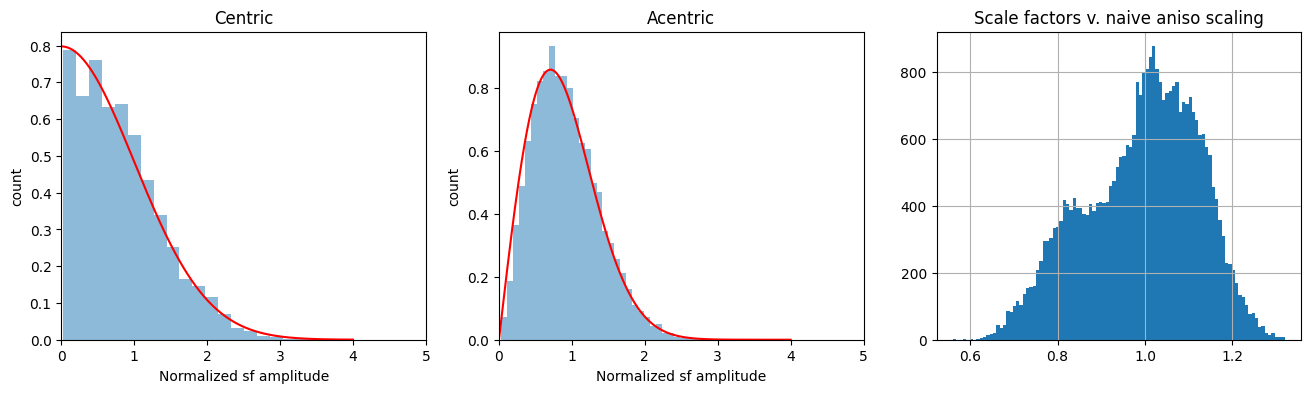

In [63]:
sig_cut = 0.01 # noisy observations deviation significantly from the Wilson distribution!
              # ironically, French-Wilson scaling seems to blame.

x=np.linspace(0,4,500)
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.hist(ep1[(ds1["CENTRIC"]==True) & (sigep1<sig_cut)],20,alpha=0.5,density=True)
plt.plot(x,wilson.wilson_dist_normalized(x,centric=True),'r-') 
plt.ylabel("count"); plt.xlabel("Normalized sf amplitude")
plt.xlim([0,5]); plt.title("Centric")

plt.subplot(1,3,2)
plt.hist(ep1[(ds1["CENTRIC"]==False) & (sigep1<sig_cut)],40,alpha=0.5,density=True)
plt.plot(x, wilson.wilson_dist_normalized(x,centric=False),'r-')
plt.ylabel("count"); plt.xlabel("Normalized sf amplitude")
plt.xlim([0,5]); plt.title("Acentric"); 

plt.subplot(1,3,3)
plt.hist(scale1,100); plt.grid()
plt.title("Scale factors v. naive aniso scaling")
plt.show()

### Corrections for the $-$ Friedel mates.
Same for the $F(-)$:

In [ ]:
# typically the minimum is for n=3 or 4...
# see right below for typical run times by n (n=4: 2-3 min total)
# note that at higher values of n sometimes NaNs pop up

res=[0] # start with a dummy so next entries match their n
n_best = 0
best_loss = 9e9
for n in [1,2,3,4,5]:
    t1_start = perf_counter()
    params = aniso2.prepare_for_FFT(ds1, n=n, label="EP-")
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        init_guess = np.zeros((1,2*(n**3)))
        if n>1:
            init_guess[0,:res[-1].x.shape[0]]=res[-1].x
        else:
            init_guess[0]=np.array([1, 0])
        res_tmp = minimize(aniso2.anisotropic_scaling_to_1_FFT_wilson_loss_fast, \
                           init_guess.flatten(),method='L-BFGS-B', jac = True, \
                           args=(params,ds1["test_flag"].to_numpy()))
        res.append(res_tmp)
        res_test = aniso2.anisotropic_scaling_to_1_FFT_wilson_loss_fast(res_tmp.x, \
                                          params, bUse=~ds1["test_flag"].to_numpy(), nargout=1)
        if res_test[0] < best_loss:
            best_loss = res_test[0]
            n_best = n
        print(f"For n = {n} the test loss = {res_test[0]:.6}")
        t1_stop = perf_counter()  
        print(f"Elapsed time: {t1_stop-t1_start:.4} s")
res_m2 = res

For n = 1 the test loss = 5832.04
Elapsed time: 1.071 s
For n = 2 the test loss = 5657.45
Elapsed time: 2.865 s
For n = 3 the test loss = 5619.43
Elapsed time: 22.93 s
For n = 4 the test loss = 5574.27
Elapsed time: 137.3 s


In [ ]:
# run for best n using *all* reflections and save
params = aniso2.prepare_for_FFT(ds1, n=n_best, label="EP-")

loss, ep1, sigep1, scale1 = aniso2.anisotropic_scaling_to_1_FFT_wilson_loss_fast(res[n_best].x, params, \
                                                        bUse=np.ones((ds1.shape[0],),dtype=bool), nargout=3)

EP1_label = "EP-_aniso_2"
ds1[EP1_label]   = ep1
ds1["SIG" + EP1_label]= sigep1
print(np.mean(ep1[ds1["CENTRIC"]==True]**2))
print(np.mean(ep1[ds1["CENTRIC"]==False]**2))

Graphical inspection:

In [ ]:
sig_cut = 0.1 # noisy observations deviation significantly from the Wilson distribution!
              # ironically, French-Wilson scaling seems to blame.

x=np.linspace(0,4,500)
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.hist(ep1[(ds1["CENTRIC"]==True) & (sigep1<sig_cut)],20,alpha=0.5,density=True)
plt.plot(x,wilson.wilson_dist_normalized(x,centric=True),'r-') 
plt.ylabel("count"); plt.xlabel("Normalized sf amplitude")
plt.xlim([0,5]); plt.title("Centric")

plt.subplot(1,3,2)
plt.hist(ep1[(ds1["CENTRIC"]==False) & (sigep1<sig_cut)],40,alpha=0.5,density=True)
plt.plot(x, wilson.wilson_dist_normalized(x,centric=False),'r-')
plt.ylabel("count"); plt.xlabel("Normalized sf amplitude")
plt.xlim([0,5]); plt.title("Acentric"); 

plt.subplot(1,3,3)
plt.hist(scale1,100); plt.grid()
plt.title("Scale factors v. naive aniso scaling")
plt.show()

## 4. Normalization by regression estimates of the scale factor $\Sigma$
We will now estimate $\left<|F|^2\right>$ locally in reciprocal space, starting from the Fourier-corrected estimates above. Because the expected intensity is the same for acentric and centric reflections, we can do this estimation for all reflections in one go.

By Rupp eq. (7-104): $ \Sigma_N = \frac{\left<I\right>}{\varepsilon_h} \quad $, so 
                    $\quad \left<I\right>=\varepsilon_h \Sigma_N $

We tried two implementations of $\Sigma$ estimation: using kernel ridge regression and k-nearest neighbors (KNN) with custom weights. The former retains more of the correlation among data sets than the latter, but is **much** slower and more memory-intensive. We therefore use the latter.

In [ ]:
temp = ds1.loc[ds1["CENTRIC"].to_numpy()==True, "EPSILON"]
print("Distribution of multiplicities for centric reflections:")
print(temp.value_counts())
print("")

temp = ds1.loc[ds1["CENTRIC"].to_numpy()==False, "EPSILON"]
print("Distribution of multiplicities for acentric reflections:")
print(temp.value_counts())

In [ ]:
EP_plus_label = "EP+_aniso_2"
EP_min_label  = "EP-_aniso_2"

### k-NN for "$+$" reflections

We now perform k-nearest neighbor regression (with self excluded). The optimal $k$ (and uniform weights) are **much higher** when the input have already been anisotropically scaled. Larger $k$ is also slower...

In [ ]:
gridsearch = False 
ncpu=1 #8 worked on the cluster
param_grid={"n_neighbors":[50,100,200,400,800],'weights':['uniform',knn.knn_weight_exp_p05, knn.knn_weight_norm_p05]}
#                                                                   knn.knn_weight_exp_p02, knn.knn_weight_norm_p02, \
#                                                                   knn.knn_weight_exp_p03, knn.knn_weight_norm_p03]}
if gridsearch: 
    knn_plus = GridSearchCV(KNeighborsRegressor(n_jobs=ncpu),param_grid=param_grid)
    knn_plus.fit(ds1[["rs_a", "rs_b", "rs_c"]].to_numpy(), (ds1[EP_plus_label].to_numpy()**2)) # these should be corrected for eps already
else:
    knn_plus = KNeighborsRegressor(800, weights=knn.knn_weight_exp_p05,n_jobs=ncpu)
    knn_plus.fit(ds1[["rs_a", "rs_b", "rs_c"]], (ds1[[EP_plus_label]].to_numpy()**2))

if gridsearch:
    print(knn_plus.best_params_)

In [ ]:
Sigma_plus = knn_plus.predict(ds1[["rs_a", "rs_b", "rs_c"]]).reshape(-1,1)

We are now ready to do the actual final normalization by dividing each amplitude by its expected value based on the KNN estimator above. That estimator only takes in the reciprocal lattice coordinates of each reflection (see the cell above).

In [ ]:
E1    = ds1[        EP_plus_label].to_numpy().reshape(-1,1)/np.sqrt(Sigma_plus) # We've already taken care of epsilon above
SIGE1 = ds1["SIG" + EP_plus_label].to_numpy().reshape(-1,1)/np.sqrt(Sigma_plus)

ds1[EP_plus_label + "_knn"]    = E1
ds1["SIG" + EP_plus_label + "_knn"] = SIGE1

### k-NN for "$-$" reflections

We now perform k-nearest neighbor regression (with self excluded). The optimal $k$ (and uniform weights) are **much higher** when the input have already been anisotropically scaled. Larger $k$ is also slower...

In [ ]:
gridsearch = False 
ncpu=1 #8 worked on the cluster
param_grid={"n_neighbors":[50,100,200,400,800],'weights':['uniform',knn.knn_weight_exp_p05, knn.knn_weight_norm_p05]}
#                                                                   knn.knn_weight_exp_p02, knn.knn_weight_norm_p02, \
#                                                                   knn.knn_weight_exp_p03, knn.knn_weight_norm_p03]}
if gridsearch: 
    knn_min = GridSearchCV(KNeighborsRegressor(n_jobs=ncpu),param_grid=param_grid)
    knn_min.fit(ds1[["rs_a", "rs_b", "rs_c"]].to_numpy(), (ds1[EP_min_label].to_numpy()**2)) # these should be corrected for eps already
else:
    knn_min = KNeighborsRegressor(800, weights=knn.knn_weight_exp_p05,n_jobs=ncpu)
    knn_min.fit(ds1[["rs_a", "rs_b", "rs_c"]], (ds1[[EP_min_label]].to_numpy()**2))

if gridsearch:
    print(knn_min.best_params_)

In [ ]:
Sigma_min = knn_min.predict(ds1[["rs_a", "rs_b", "rs_c"]]).reshape(-1,1)

In [ ]:
E1    = ds1[        EP_min_label].to_numpy().reshape(-1,1)/np.sqrt(Sigma_min) # We've already taken care of epsilon above
SIGE1 = ds1["SIG" + EP_min_label].to_numpy().reshape(-1,1)/np.sqrt(Sigma_min)

ds1[EP_min_label + "_knn"]    = E1
ds1["SIG" + EP_min_label + "_knn"] = SIGE1

# Analysis

To check how well we have removed resolution-dependent systematic variation, we plot |E| as a function of resolution. 

In [ ]:
plt.figure(figsize=(16,3.5))
plt.subplot(1,3,1)
result_p, bin_labels_p = plots.compute_meanF_byres(ds1, label="FP+", nbins=20,sigma_cut=0)
result_m, bin_labels_m = plots.compute_meanF_byres(ds1, label="FP-", nbins=20,sigma_cut=0)
plots.plot_by_res_bin(result_p, bin_labels_p, ylabel="mean F",color='b')
plots.plot_by_res_bin(result_m, bin_labels_m, ylabel="mean F",color='g')
plt.legend(["FP(+)","FP(-)"])
plt.title("Mean |F|")
plt.ylim(0,)

plt.subplot(1,3,2)
result_1p, bin_labels_1p = plots.compute_meanF_byres(ds1, label="EP+",                nbins=20,sigma_cut=0)
result_2p, bin_labels_2p = plots.compute_meanF_byres(ds1, label=EP_plus_label,        nbins=20,sigma_cut=0)
result_3p, bin_labels_3p = plots.compute_meanF_byres(ds1, label=EP_plus_label+"_knn", nbins=20,sigma_cut=0)
result_1m, bin_labels_1m = plots.compute_meanF_byres(ds1, label="EP-",                nbins=20,sigma_cut=0)
result_2m, bin_labels_2m = plots.compute_meanF_byres(ds1, label=EP_min_label,         nbins=20,sigma_cut=0)
result_3m, bin_labels_3m = plots.compute_meanF_byres(ds1, label=EP_min_label+"_knn",  nbins=20,sigma_cut=0)
plots.plot_by_res_bin(result_1p, bin_labels_1p, ylabel="mean E",color='b')
plots.plot_by_res_bin(result_2p, bin_labels_2p, ylabel="mean E",color='r')
plots.plot_by_res_bin(result_3p, bin_labels_3p, ylabel="mean E",color='g')
plots.plot_by_res_bin(result_1m, bin_labels_1m, ylabel="mean E",color='b')
plots.plot_by_res_bin(result_2m, bin_labels_2m, ylabel="mean E",color='r')
plots.plot_by_res_bin(result_3m, bin_labels_3m, ylabel="mean E",color='g')
plt.title("Mean |F|")
plt.legend(["EP+ (aniso_1)", "EP+ (aniso_2)","EP+ (knn)","EP- (aniso_1)", "EP- (aniso_2)","EP- (knn)"])
plt.ylim(0,)

plt.subplot(1,3,3)
result_1p, bin_labels_1p = plots.compute_meanFsq_byres(ds1, label="EP+",                nbins=20,sigma_cut=0)
result_2p, bin_labels_2p = plots.compute_meanFsq_byres(ds1, label=EP_plus_label,        nbins=20,sigma_cut=0)
result_3p, bin_labels_3p = plots.compute_meanFsq_byres(ds1, label=EP_plus_label+"_knn", nbins=20,sigma_cut=0)
result_1m, bin_labels_1m = plots.compute_meanFsq_byres(ds1, label="EP-",                nbins=20,sigma_cut=0)
result_2m, bin_labels_2m = plots.compute_meanFsq_byres(ds1, label=EP_min_label,         nbins=20,sigma_cut=0)
result_3m, bin_labels_3m = plots.compute_meanFsq_byres(ds1, label=EP_min_label+"_knn",  nbins=20,sigma_cut=0)
plots.plot_by_res_bin(result_1p, bin_labels_1p, ylabel=r"mean $|E|^2$",color='b')
plots.plot_by_res_bin(result_2p, bin_labels_2p, ylabel=r"mean $|E|^2$",color='r')
plots.plot_by_res_bin(result_3p, bin_labels_3p, ylabel=r"mean $|E|^2$",color='g')
plots.plot_by_res_bin(result_1m, bin_labels_1m, ylabel=r"mean $|E|^2$",color='b')
plots.plot_by_res_bin(result_2m, bin_labels_2m, ylabel=r"mean $|E|^2$",color='r')
plots.plot_by_res_bin(result_3m, bin_labels_3m, ylabel=r"mean $|E|^2$",color='g')
plt.title(r"Mean $|F|^2$")
plt.legend(["EP+ (aniso_1)", "EP+ (aniso_2)","EP+ (knn)","EP- (aniso_1)", "EP- (aniso_2)","EP- (knn)"])
plt.ylim(0,)
plt.show()

In the right plot, we see that individual preprocessing steps have flattened the mean |E| per resolution bin, as a function of resolution. Now, we examine the distribution of resolution and |E|. 

Let's now look at the distribution of normalized amplitudes across _marginal_ percentile bins. If the normalization worked well, these 2D histograms are relatively uniform. Deviations highlight limitations of the normalization. Typically the most pronounced effect is depletion of low amplitudes & overrepresentation of amplitudes around the mode of the distribution at high resolution. This is an artifact of French-Wilson scaling.

In [ ]:
# Let's examine the distribution of dHKL and E in the (+) data
sig_cut = 1 # do not include reflections with errors larger than this. do not make this smaller than about 0.5 or many reflections will be depleted at high res.
nbin    = (20,10)

cdf_bins     = np.linspace(0,100,nbin[0]+1)
d_bins       = np.percentile(ds1["dHKL"], cdf_bins)
d_bins[-1]   = d_bins[-1]+1e-6   # to avoid omitting the largest data point
d_dig        = np.digitize(ds1["dHKL"], d_bins)
ds1["dHKL_bin"] = d_dig.flatten()
# print(d_bins)

cdf_bins     = np.linspace(0,100,nbin[1]+1)
ep1_bins     = np.percentile(ds1[EP_plus_label], cdf_bins)
ep1_bins[-1] = ep1_bins[-1]+1e-6 # to avoid omitting the largest data point
ep1_dig      = np.digitize(ds1[EP_plus_label], ep1_bins)
ds1["EP_1_bin"] = ep1_dig.flatten()

H, xedges, yedges = np.histogram2d(ds1.loc[(ds1["CENTRIC"]==False) & (ds1["SIG" + EP_plus_label]<sig_cut), "dHKL_bin"], \
                                   ds1.loc[(ds1["CENTRIC"]==False) & (ds1["SIG" + EP_plus_label]<sig_cut), "EP_1_bin"],bins=nbin)

plt.figure(figsize=(10,8))
im=plt.imshow(H.transpose(), interpolation='nearest', origin='lower',\
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],vmin=0)
plt.xlabel("resolution bin (high to low)")
plt.ylabel("|E| bin")
plt.title("Counts per 2D bin for |E| and dHKL")
plt.colorbar(im,fraction=0.025, pad=0.04)

fname = mtz1 + "_n" + str(n_best) + "_" + EP1_label + "_" + str(rseed)+ ".png"
plt.savefig("results_figs/" + fname)
plt.show()

For each resolution bin, the distribtion of |E| looks pretty flat! 

## Cleaning up 

In [ ]:
# ds1.info()

Finally, we clean up the mtz datatypes before further analysis. 

In [ ]:
ds1["rs_a"]           = ds1["rs_a"           ].astype("MTZReal")
ds1["rs_b"]           = ds1["rs_b"           ].astype("MTZReal")
ds1["rs_c"]           = ds1["rs_c"           ].astype("MTZReal")
ds1["I(+)"]           = ds1["I(+)"           ].astype("FriedelIntensity")
ds1["I(-)"]           = ds1["I(-)"           ].astype("FriedelIntensity")
ds1["SIGI(+)"]        = ds1["SIGI(+)"        ].astype("StddevFriedelI")
ds1["SIGI(-)"]        = ds1["SIGI(-)"        ].astype("StddevFriedelI")
ds1["FP+"]            = ds1["FP+"            ].astype("FriedelSFAmplitude")
ds1["FP-"]            = ds1["FP-"            ].astype("FriedelSFAmplitude")
ds1["SIGFP+"]         = ds1["SIGFP+"         ].astype("StddevFriedelSF")
ds1["SIGFP-"]         = ds1["SIGFP-"         ].astype("StddevFriedelSF")
ds1["EP+"]            = ds1["EP+"            ].astype("NormalizedSFAmplitude")
ds1["EP-"]            = ds1["EP-"            ].astype("NormalizedSFAmplitude")
ds1["SIGEP+"]         = ds1["SIGEP+"         ].astype("Stddev")
ds1["SIGEP-"]         = ds1["SIGEP-"         ].astype("Stddev")
ds1["EP+_aniso_2"]    = ds1["EP+_aniso_2"    ].astype("NormalizedSFAmplitude")
ds1["EP-_aniso_2"]    = ds1["EP-_aniso_2"    ].astype("NormalizedSFAmplitude")
ds1["SIGEP+_aniso_2"] = ds1["SIGEP+_aniso_2" ].astype("Stddev")
ds1["SIGEP-_aniso_2"] = ds1["SIGEP-_aniso_2" ].astype("Stddev")

ds1["EP+_aniso_2_knn"]    = ds1["EP+_aniso_2_knn"   ].astype("NormalizedSFAmplitude")
ds1["EP-_aniso_2_knn"]    = ds1["EP-_aniso_2_knn"   ].astype("NormalizedSFAmplitude")
ds1["SIGEP+_aniso_2_knn"] = ds1["SIGEP+_aniso_2_knn"].astype("Stddev")
ds1["SIGEP-_aniso_2_knn"] = ds1["SIGEP-_aniso_2_knn"].astype("Stddev")
ds1["CENTRIC"]            = ds1["CENTRIC"           ].astype("MTZInt")

# ds1.info()

Let's check whether we still have unsupported column datatypes around!

In [ ]:
# rs.summarize_mtz_dtypes(print_summary=True)
modify_ds.check_col_dtypes(ds1)

In [ ]:
# We'll have to add centric flags back later
ds1.write_mtz(path + mtz1 + "_scaled.mtz",skip_problem_mtztypes=True)
t_overall_end = perf_counter()
print("Total elapsed time:", t_overall_end-t_overall_start)